# Optimisation of the cADpyr_L5TPC metype

This notebook displays the results of the optimisation run for the cADpyr_L5TPC metype. The optimisation is performed using the BluePyOpt software.


In [1]:
from contextlib import contextmanager
import pickle
import os
import subprocess
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from opt_module.setup.evaluator import create as create_evaluator
from opt_module.tools.analyse import Analyse
from opt_module.tools.plot import diversity
from opt_notebook_plots import plot_objectives, plot_log

See the requirements.txt file for python package dependencies.

#### Compile the NEURON mechanisms using the nrnivmodl command

The mod files inside the `mechanisms` folder need to be compiled. The output of compilation will be saved into the `compilation_output` variable.
It can be displayed for debugging.

In [3]:
compilation_output = subprocess.run(["nrnivmodl", "opt_module/mechanisms"], capture_output=True, check=True)

## Optimisation Checkpoint

A checkpoint file is provided from the optimisation run to cover the necessary information to restore the evolution. BluePyOpt uses DEAP framework for the evolutionary algorithm implementations. Further information about checkpointing can be found at the DEAP documentation.
https://deap.readthedocs.io/en/master/tutorials/advanced/checkpoint.html

Checkpoint file is a pickle file therefore can be loaded with the built-in pickle module.

In [4]:
checkpoint_file = (
    Path("opt_module")
    / "checkpoints"
    / "run.a6e707a"
    / "cADpyr_L5TPC_1.pkl"
)

In [5]:
metype = "cADpyr_L5TPC"

In [6]:
with open(checkpoint_file, 'rb') as file_handle:
    cp = pickle.load(file_handle, encoding="latin1") 

The checkpoint is a dictionary containing the following keys.

In [7]:
cp.keys()

dict_keys(['history', 'parents', 'generation', 'logbook', 'rndstate', 'halloffame', 'population'])

### Logbook

Logbook variable contains the chronological recordings of the evolution.
https://deap.readthedocs.io/en/master/api/tools.html?highlight=logbook#logbook

In [8]:
type(cp["logbook"])

deap.tools.support.Logbook

The figure below shows the population minimum alongside with the population's standard deviation through the generations.


The dark blue line in the figure is denoting the population's minimum.

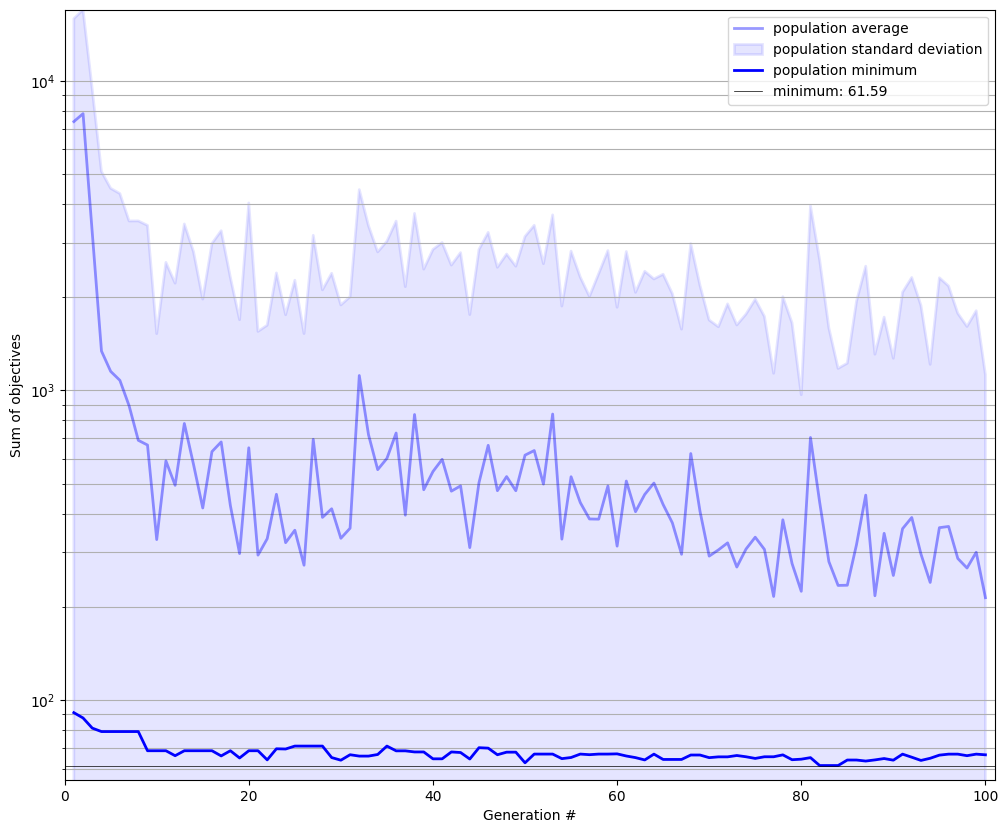

In [9]:
log_plot_fig = plot_log(cp["logbook"])

### History

The history variable contains the genealogy tree and the genealogy history of the individuals.
https://deap.readthedocs.io/en/master/api/tools.html?highlight=history#deap.tools.History

In [10]:
type(cp["history"])

deap.tools.support.History

### Hall of Fame

In [11]:
type(cp["halloffame"])

deap.tools.support.HallOfFame

The hall of fame contains the best individual that ever lived in the population during the evolution. It is lexicographically sorted at all time so that the first element of the hall of fame is the individual that has the best first fitness value ever seen, according to the weights provided to the fitness at creation time. 
https://deap.readthedocs.io/en/master/api/tools.html?highlight=halloffame#deap.tools.HallOfFame

## Custom Evaluator

The custom evaluator used in optimising cADpyr_L5TPC can be loaded as follows.

In [12]:
apical_points_file = os.path.join(".","opt_module", "morphologies", "apical_points_isec.json")

In [13]:
evaluator = create_evaluator(metype, apical_points_file)

--No graphics will be displayed.


### Parameters

The parameters and their boundaries.

In [14]:
print(*[(param.name, param.bounds) for param in evaluator.params], sep="\n")

('constant.distribution_decay', [-0.1, 0.0])
('g_pas.all', [1e-05, 6e-05])
('e_pas.all', [-95, -60])
('gIhbar_Ih.somadend', [0, 0.0002])
('gNaTgbar_NaTg.axonal', [0, 1.5])
('gNap_Et2bar_Nap_Et2.axonal', [0, 0.02])
('gK_Pstbar_K_Pst.axonal', [0, 1])
('gK_Tstbar_K_Tst.axonal', [0, 0.2])
('gSKv3_1bar_SKv3_1.axonal', [0, 1])
('gCa_HVAbar_Ca_HVA2.axonal', [0, 0.001])
('gCa_LVAstbar_Ca_LVAst.axonal', [0, 0.01])
('gSK_E2bar_SK_E2.axonal', [0, 0.1])
('decay_CaDynamics_DC0.axonal', [20, 300])
('gamma_CaDynamics_DC0.axonal', [0.005, 0.05])
('gNaTgbar_NaTg.somatic', [0, 0.3])
('gK_Pstbar_K_Pst.somatic', [0, 0.2])
('gK_Tstbar_K_Tst.somatic', [0, 0.1])
('gSKv3_1bar_SKv3_1.somatic', [0, 1])
('gCa_HVAbar_Ca_HVA2.somatic', [0, 0.001])
('gCa_LVAstbar_Ca_LVAst.somatic', [0, 0.01])
('gSK_E2bar_SK_E2.somatic', [0, 0.1])
('decay_CaDynamics_DC0.somatic', [20, 300])
('gamma_CaDynamics_DC0.somatic', [0.005, 0.05])
('gamma_CaDynamics_DC0.apical', [0.005, 0.05])
('gNaTgbar_NaTg.apical', [0, 0.1])
('gSKv3_1bar_S

### Objectives

In [15]:
hof = cp["halloffame"]
rank = 0
hof_objectives = evaluator.objective_dict(hof[rank].fitness.values)

The figure belows describes the objectives from the hall of fame cell model at rank 0.

Sum of objectives: 61.59313759347834 (# std)


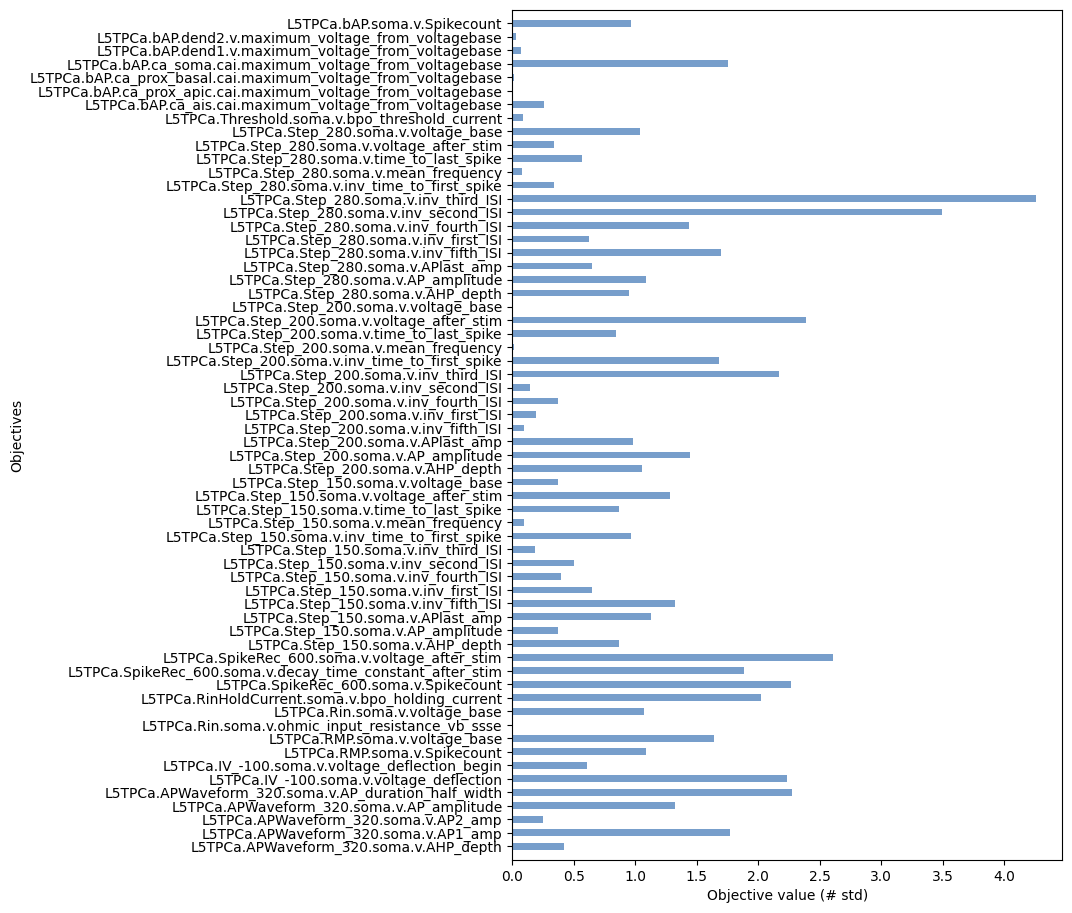

In [16]:
objectives_plot = plot_objectives(hof_objectives)

### Diversity

The figure below shows the whole history, hall of fame models as well as the best individual for each parameter.

n_params: 31
fitness_cut_off: 123.18627518695679


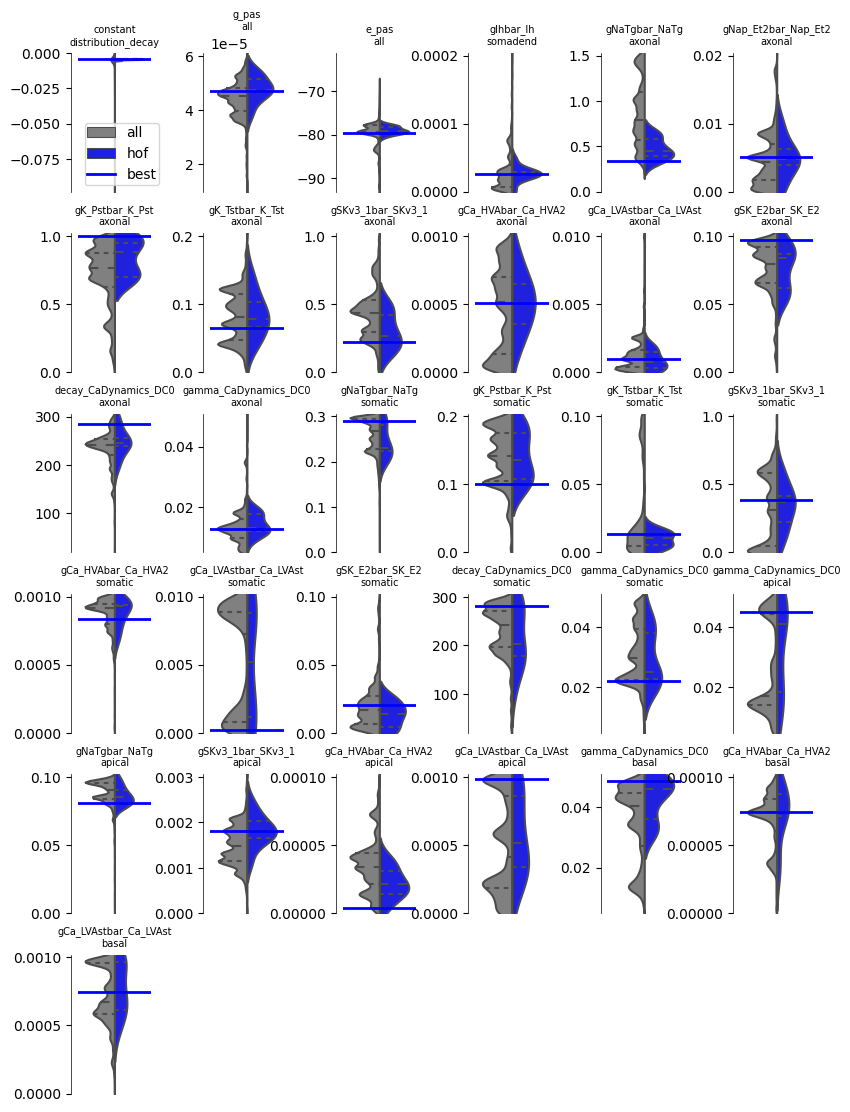

In [17]:
diversity_fig = diversity(cp, evaluator)

## Responses

Get the responses of the top individual (the individual at rank 0)

In [18]:
def get_responses(cell_evaluator, top_individual):
    """Get voltage, calcium recording, threshold and holding currents from the individual."""
    individual_dict = cell_evaluator.param_dict(top_individual)
    responses = cell_evaluator.run_protocols(
            cell_evaluator.fitness_protocols.values(), param_values=individual_dict)

    return responses

@contextmanager
def cwd(path):
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

In [19]:
with cwd("opt_module"):
    analysis_obs = Analyse(
        githash="a6e707a",
        seed=1,
        rank=0,
        etype="cADpyr_L5TPC",
        main_path="opt_module",
        recipes_path="./config/recipes/recipes.json",
        stage=2,
    )

    analyse = analysis_obs

    hof = cp["halloffame"]
    top_individual = hof[0]
    analyse.set_evaluator()

    responses = get_responses(analyse.evaluator.evaluators[0], top_individual)


{}
Max threshold current: 1.16583
Using cADpyr_L5TPC[0].apic[9](0.476537) at distance 208.351722
Using cADpyr_L5TPC[0].apic[13](0.355431) at distance 399.772106
Using cADpyr_L5TPC[0].apic[3](0.224884) at distance 46.266262
Using cADpyr_L5TPC[0].dend[2](0.168275) at distance 42.786308, nseg 5.000000, length 105.656220


If you are getting the following error, then the extra mechanisms are not compiled successfully.

```
ValueError: argument not a density mechanism name.: CaDynamics_DC0
```

To solve it, shut down the notebook and run the following command on the same directory as this notebook.

```
nrnivmodl opt_module/mechanisms
```

That will create a folder called `x86_64`. Once that folder is present and the aforementioned mechanism  files are inside, the error will vanish.

In [20]:
list(responses.keys())

['L5TPCa.RMP.soma.v',
 'L5TPCa.Rin.soma.v',
 'L5TPCa.bpo_holding_current',
 'L5TPCa.bpo_threshold_current',
 'L5TPCa.bAP.soma.v',
 'L5TPCa.bAP.dend1.v',
 'L5TPCa.bAP.dend2.v',
 'L5TPCa.bAP.ca_prox_apic.cai',
 'L5TPCa.bAP.ca_prox_basal.cai',
 'L5TPCa.bAP.ca_soma.cai',
 'L5TPCa.bAP.ca_ais.cai',
 'L5TPCa.Step_150.soma.v',
 'L5TPCa.Step_200.soma.v',
 'L5TPCa.Step_280.soma.v',
 'L5TPCa.APWaveform_320.soma.v',
 'L5TPCa.IV_-100.soma.v',
 'L5TPCa.SpikeRec_600.soma.v']

### The holding and threshold current values

In [21]:
currents = {k: v for k, v in responses.items() if k.endswith("current")}
currents

{'L5TPCa.bpo_holding_current': -0.14824624653558993,
 'L5TPCa.bpo_threshold_current': 0.47628416142033836}

### Voltage recordings

In [22]:
voltage_responses = {k: v for k, v in responses.items() if k.endswith(".v")}

In [23]:
n_voltage_responses = len(voltage_responses.items())

#### List of voltage recordings

In [24]:
list(voltage_responses)

['L5TPCa.RMP.soma.v',
 'L5TPCa.Rin.soma.v',
 'L5TPCa.bAP.soma.v',
 'L5TPCa.bAP.dend1.v',
 'L5TPCa.bAP.dend2.v',
 'L5TPCa.Step_150.soma.v',
 'L5TPCa.Step_200.soma.v',
 'L5TPCa.Step_280.soma.v',
 'L5TPCa.APWaveform_320.soma.v',
 'L5TPCa.IV_-100.soma.v',
 'L5TPCa.SpikeRec_600.soma.v']

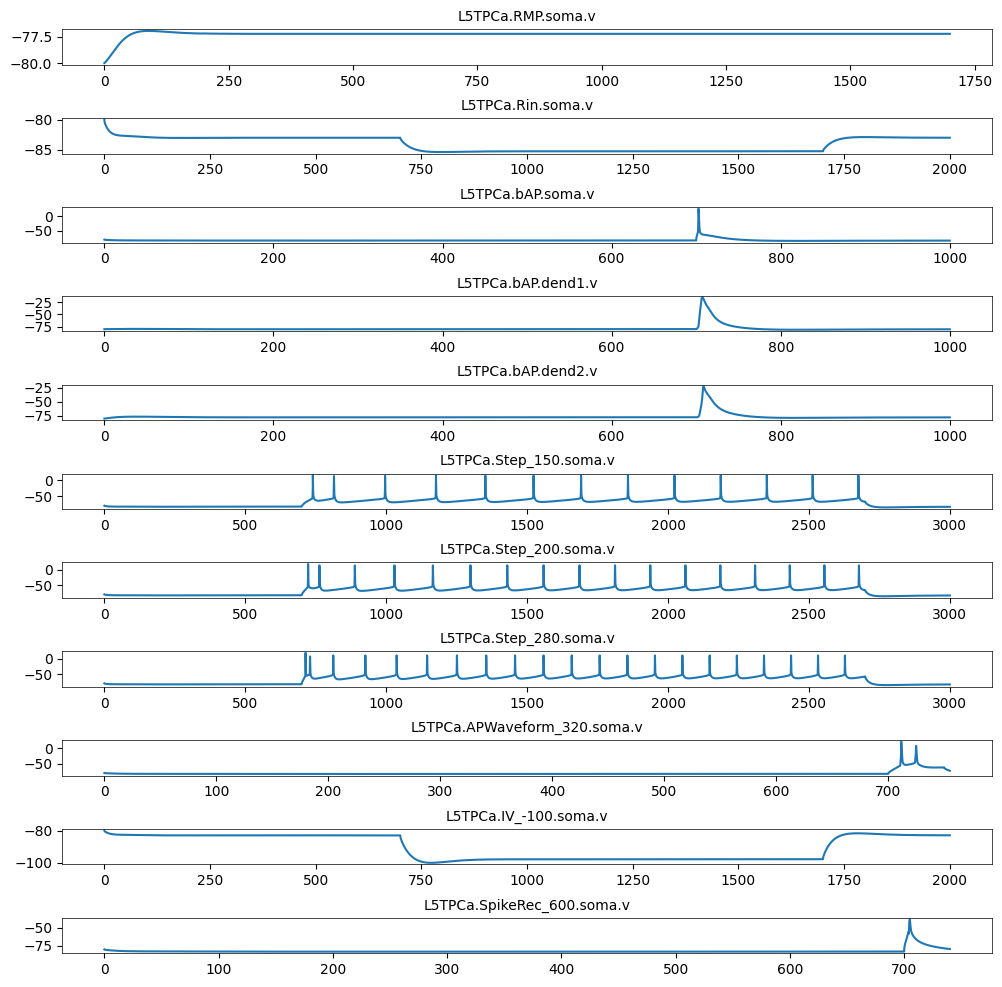

In [25]:
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(n_voltage_responses, hspace=1.5)
axs = gs.subplots()
for i, response_key in enumerate(voltage_responses):
    axs[i].set_title(response_key)
    voltage_responses[response_key].plot(axs[i])
    # np.savetxt(f"tests/voltage_responses/{response_key}.dat", voltage_responses[response_key].response)

### Calcium recordings

In [26]:
ca_responses = {k: v for k, v in responses.items() if k.endswith(".cai")}

In [27]:
n_ca_responses = len(ca_responses.items())

#### List of calcium recordings

In [28]:
list(ca_responses)

['L5TPCa.bAP.ca_prox_apic.cai',
 'L5TPCa.bAP.ca_prox_basal.cai',
 'L5TPCa.bAP.ca_soma.cai',
 'L5TPCa.bAP.ca_ais.cai']

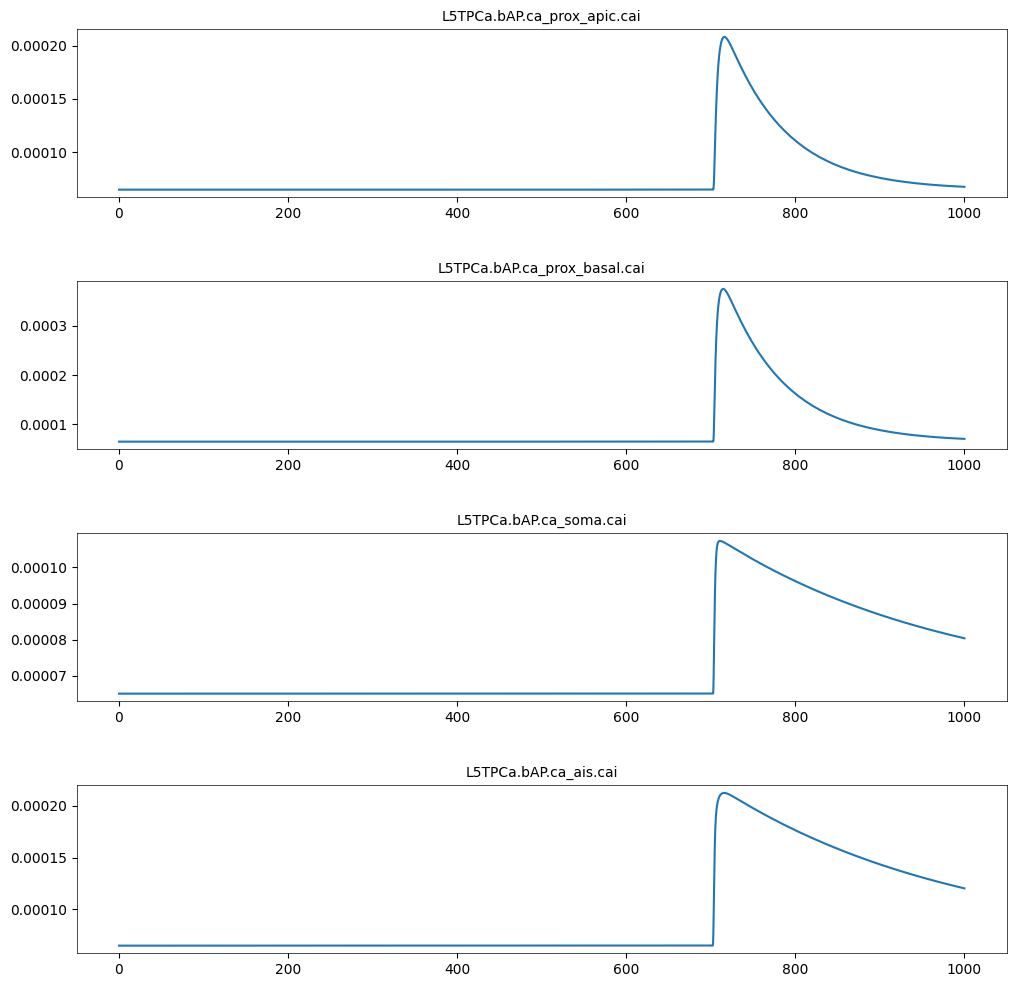

In [29]:
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(n_ca_responses, hspace=0.5)
axs = gs.subplots()
for i, response_key in enumerate(ca_responses):
    axs[i].set_title(response_key)
    ca_responses[response_key].plot(axs[i])
    # np.savetxt(f"tests/calcium_responses/{response_key}.dat", ca_responses[response_key].response)